## Learning Risk-neutral measures with Neural Networks


The goal is using a neural network to learn the risk-neutral probability density function of the underlying asset from option data. In this notebook we are using options data from the JPX Tokyo Stock Exchange Prediction competition. In particular, we consider the European options on the NIKKEI225 index. Based on the spot prices of some of these options trading on a specific date, we learn the density function $p$ of the price of the index at the maturity time $T$ of the options. The knowledge of $p$ ha many potential applications. In this notebook we are able to deduce the price of options that are trading at the sime time as ours but of different kind and with different strikes than the ones of the training set.  

To open the notebook on Kaggle, where the training data is, go to https://www.kaggle.com/code/michelemeziu/semester-project-notebook/

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from scipy.stats import lognorm
from scipy.ndimage.filters import uniform_filter1d
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datetime import date, datetime

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [2]:
#integration parameters
INTERVAL_LENGTH = 10
START_UNIF = 0.01
SCALING_CONSTANT = 10000

In [3]:
options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We look at options trading on $\texttt{trading_date}$ and expiring on $\texttt{option_expiry}$

In [4]:
option_expiry = 20170112
trading_date = '2017-01-04'

We select the options from the dataset, and scale the prices according to SCALING_CONSTANT. This improves learning 
for the network.

In [5]:
pd.set_option('display.max_columns', None)
dataset = options.loc[(options['LastTradingDay'] == option_expiry)
                      & (options['WholeDayVolume']> 0) 
                      & (options['Date'] == trading_date)][['StrikePrice', 'Putcall', 'SettlementPrice']]    #[['WholeDayClose', 'SettlementPrice']]
dataset[['StrikePrice', 'SettlementPrice']] = dataset[['StrikePrice', 'SettlementPrice']].transform(lambda x : x/SCALING_CONSTANT)
dataset['Putcall'] = dataset['Putcall'].transform(lambda x : False if x==1 else True)

In [6]:
train_df, test_df = train_test_split(dataset, test_size = 0.2)

In [7]:
len(train_df)

60

In [8]:
len(test_df)

15

For both the training and test data we feed in all the data in a single batch. There is no validation data.

In [9]:
prices_and_strikes = [ (train_df['SettlementPrice'].iloc[i], train_df['StrikePrice'].iloc[i], train_df['Putcall'].iloc[i]) for i in range(len(train_df))]
train_set_size = len(prices_and_strikes)
batch_size = train_set_size
target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)

In [10]:
test_prices_and_strikes = [ (test_df['SettlementPrice'].iloc[i], test_df['StrikePrice'].iloc[i], test_df['Putcall'].iloc[i]) for i in range(len(test_df))]
test_set_size = len(test_prices_and_strikes)
batch_size = len(test_prices_and_strikes)
test_dataloader = DataLoader(test_prices_and_strikes , batch_size=batch_size, shuffle = True)

The following network learns the risk-neutral density, i.e. given a price for the index outputs the probability density of the index having that price at maturity $T$. The network is a vanilla neural network with leaky ReLU activation for intermediate layers and softplus in the last year. The condition that the integral over the NN's domain is $1$ is not enforced explicitely but is rather learned from the data.

In [11]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 512),
            nn.LeakyReLU(1e-1),   

            nn.Linear(512, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 1)
        )
        self.softplus = nn.Softplus()
        
        
    def forward(self, x):
        x = self.flatten(x)
        y = torch.log(x)
        x = self.linear_relu_stack(torch.cat((x,y), 1))
        x = self.softplus(x)
        return x

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model_eq = BaselineNet().to(device)

Using cpu device


The loss function used to train the NN as described on the semester project on https://github.com/Antares01/NNs_for_option_pricing_semester_project

In [13]:
class OptionLoss(nn.Module):
    def __init__(self):
        super(OptionLoss,self).__init__()
        self.huber = nn.HuberLoss()
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        mc_steps = len(coordinates)
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(len(outputs)), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(len(outputs)), strike[j] - coordinates)
        density = 1/INTERVAL_LENGTH 
        mc_prices = torch.stack([ torch.sum(payoff(j) * outputs / density)/mc_steps for j in range(len(labels))])
        
        return self.huber(mc_prices/labels, torch.ones_like(labels))


The following class is used only for computing a score for testing the model and not for training. It computes the absolute value of the average deviation (in percentage) between the predicted price and the true option price.

In [14]:
class AbsolutePercentageLoss(nn.Module):
    def __init__(self):
        super(AbsolutePercentageLoss, self).__init__()
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        mc_steps = len(coordinates)
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(len(outputs)), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(len(outputs)), strike[j] - coordinates)
        densities = 1/INTERVAL_LENGTH 
        for j in range(len(labels)):
          mc_price = payoff(j) * outputs / densities
          #print("true price " + str(labels[j]) )
          #print("predicted price " + str(mc_price.sum() / mc_steps) )
          #print("absolute difference " + str(torch.abs(labels[j] -  mc_price.sum() / mc_steps)))
          print("delta (percentage of true price)" + str(torch.abs(labels[j] -  mc_price.sum() / mc_steps)/labels[j]) )
          loss += torch.abs(labels[j] -  mc_price.sum() / mc_steps)/labels[j]
        return loss  
            

In [15]:
test_error = AbsolutePercentageLoss()

In [16]:
optimizer_eq = torch.optim.Adam(model_eq.parameters(), lr=1e-4, weight_decay=1e-20)
loss_fn = OptionLoss()
test_error = AbsolutePercentageLoss()

In the training loop we use scheduling, i.e. for the first iterations we evaluate the NN on few points to quickly learn the approximate shape of the disstribution. Afterwards we gradually increase the number of points to fine tune the network.

In [17]:
def train(input_model, optimizer, loss_fn, C1, C2, target_dataloader, equidistant_window=False):
    loss_history = []
    for epoch in tqdm(range(int(396*C1))):
        avg_loss = 0
        for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
            if epoch < 100 * C1:
                mc_steps = int(128*C2)
            elif epoch < 300 * C1:
                mc_steps = int(256*C2)
                if epoch == int(100* C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density1.png")
                    plt.close()
            elif epoch < 350 * C1:
                #change to relative mse maybe
                mc_steps = int(512*C2)
                if epoch == int(300 * C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density2.png")
                    plt.close()
            elif epoch < 375 * C1:
                mc_steps = int(1024*C2)
                if epoch == int(350 * C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density3.png")
                    plt.close()
            elif epoch < 387 * C1:
                mc_steps = int(2048*C2)
                if epoch == int(375 * C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density4.png")
                
            elif epoch < 393*C1:
                mc_steps = int(4096*C2)
                if epoch == int(387 * C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density5.png")
                    plt.close()
            else:
                mc_steps = int(8192*C2)
            
            
            if equidistant_window:
                coordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*mc_steps),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*mc_steps),num=mc_steps)+np.random.uniform(low=-INTERVAL_LENGTH/(2*mc_steps),high=INTERVAL_LENGTH/(2*mc_steps),size=mc_steps)
                coordinates = coordinates.reshape(  -1, 1)
                X = torch.tensor(coordinates, dtype = torch.float32).to(device)
                

            else:
                X = torch.zeros(mc_steps, 1).to(device)
                X.uniform_(START_UNIF, INTERVAL_LENGTH)



            #print(X)
            #X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA )
            #print(X)
            pred = input_model(X)
            loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(input_model.parameters(), 1e-1)
            optimizer.step()
            avg_loss += loss
        loss_history.append(float(avg_loss/(batch + 1)))
    return loss_history

In [18]:
def test(model, loss_fn, test_dataloader, mc_steps = 4096):
    # only one single batch used
    for batch, (target_prices, strike_prices, is_call) in enumerate(test_dataloader):
        coordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*mc_steps),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*mc_steps),num=mc_steps)+np.random.uniform(low=-INTERVAL_LENGTH/(2*mc_steps),high=INTERVAL_LENGTH/(2*mc_steps),size=mc_steps)
        coordinates = coordinates.reshape(  -1, 1)
        X = torch.tensor(coordinates, dtype = torch.float32).to(device)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
    return loss/len(test_dataloader)


In [19]:
loss_history_eq = train(model_eq, optimizer_eq, loss_fn, 20, 2, target_dataloader, equidistant_window = True)

100%|██████████| 7920/7920 [13:25<00:00,  9.84it/s]


In [20]:
x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
p_eq = model_eq(x)
plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
plt.savefig("/kaggle/working/final_density.png")
plt.close()

In [21]:
x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
p_eq = model_eq(x)
plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
plt.yscale("log")
plt.savefig("/kaggle/working/logdensity.png")
plt.close()

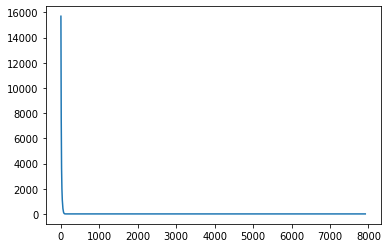

In [22]:
plt.plot(range(len(loss_history_eq)), loss_history_eq)

In [23]:
plt.plot(range(len(loss_history_eq)), loss_history_eq)
plt.yscale("log")
plt.savefig("/kaggle/working/loghistory.png")
plt.close()

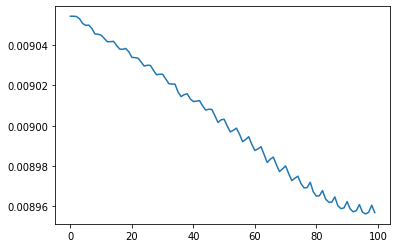

In [24]:
running_loss_average_eq = uniform_filter1d(loss_history_eq, size=50)
plt.plot(range(len(running_loss_average_eq[-100:])), running_loss_average_eq[-100:])

In [25]:
total_error = test(model_eq, test_error, test_dataloader)
average_error = total_error.detach().numpy() / len(test_prices_and_strikes)
print(average_error)

delta (percentage of true price)tensor(0.0342, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0874, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.1252, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0564, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0187, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.2262, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0522, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.2430, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0519, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.1638, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.2389, dtype=torch.float64, grad_fn=<Div

In [26]:
#x = torch.Tensor(np.arange(0.001, 20, 0.01)).to(device).unsqueeze(-1)
#p = np.array(model(x).detach())
#print(np.argmax(p)*0.01*SCALING_CONSTANT)